In [1]:
!pip install -q huggingface_hub

from huggingface_hub import notebook_login

# Chạy dòng này và nhập token vào ô hiện ra
notebook_login()


In [3]:
import pandas as pd

# Login using e.g. `huggingface-cli login` to access this dataset
splits = {'train': 'train_set.csv', 'validation': 'val_set.csv', 'test': 'test_set.csv'}
df_train = pd.read_csv("hf://datasets/hung20gg/NEU-ESC/" + splits["train"])
df_val = pd.read_csv("hf://datasets/hung20gg/NEU-ESC/" + splits["validation"])
df_test = pd.read_csv("hf://datasets/hung20gg/NEU-ESC/" + splits["test"])

In [4]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")
model = AutoModelForMaskedLM.from_pretrained("vinai/phobert-base-v2")

config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

🔍 Missing values:
text              0
classification    0
dtype: int64
🔍 Số dòng trùng lặp: 0

🔍 Phân bố nhãn classification:
classification
3.0    14402
2.0    10512
4.0     2358
6.0     1478
1.0      902
5.0      808
7.0      769
8.0      670
9.0      662
0.0      405
Name: count, dtype: int64


model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

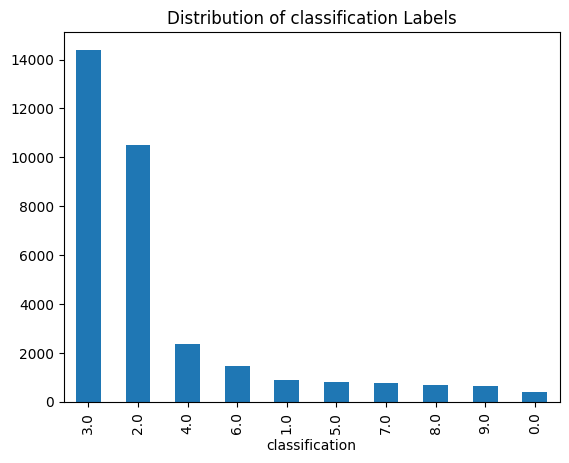


🔍 Kiểm tra nhiễu:
url: 0 dòng chứa
emoji/symbol: 1 dòng chứa
html: 0 dòng chứa


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import re


df = pd.concat([df_train, df_val, df_test])

# 1. Xóa cột classification
if "sentiment" in df.columns:
    df = df.drop(columns=["sentiment"])

# 2. Kiểm tra missing values
print("🔍 Missing values:")
print(df.isnull().sum())

# 3. Kiểm tra dữ liệu trùng lặp
duplicates = df.duplicated().sum()
print(f"🔍 Số dòng trùng lặp: {duplicates}")

# 4. Thống kê phân bố nhãn sentiment
print("\n🔍 Phân bố nhãn classification:")
print(df["classification"].value_counts())

df["classification"].value_counts().plot(kind="bar", title="Distribution of classification Labels")
plt.show()



# 5. Kiểm tra nhiễu trong text
def check_noise(text):
    issues = {}
    # URL
    if re.search(r"http\S+|www\.\S+", text):
        issues["url"] = True
    # Emoji (ký tự nằm ngoài khoảng latin cơ bản)
    if re.search(r"[^\w\s,.!?;:()\-–—]", text):
        issues["emoji/symbol"] = True
    # HTML tags
    if re.search(r"<[^>]+>", text):
        issues["html"] = True
    return issues

noise_counts = {"url": 0, "emoji/symbol": 0, "html": 0}
for t in df["text"].dropna():
    issues = check_noise(str(t))
    for k in issues:
        noise_counts[k] += 1

print("\n🔍 Kiểm tra nhiễu:")
for k, v in noise_counts.items():
    print(f"{k}: {v} dòng chứa")



In [6]:
# Calculate the lengths of the original dataframes
len_train = len(df_train)
len_val = len(df_val)
len_test = len(df_test)

# Split the concatenated dataframe based on the original lengths
df_train_split = df.iloc[:len_train]
df_val_split = df.iloc[len_train : len_train + len_val]
df_test_split = df.iloc[len_train + len_val :]

# Display the shapes of the split dataframes to verify
print("Shape of df_train_split:", df_train_split.shape)
print("Shape of df_val_split:", df_val_split.shape)
print("Shape of df_test_split:", df_test_split.shape)

Shape of df_train_split: (23048, 2)
Shape of df_val_split: (3305, 2)
Shape of df_test_split: (6613, 2)


In [7]:
from datasets import Dataset

df_train_split = df_train_split.rename(columns={"classification": "labels"})
df_val_split   = df_val_split.rename(columns={"classification": "labels"})
df_test_split  = df_test_split.rename(columns={"classification": "labels"})

train_dataset = Dataset.from_pandas(df_train_split)
val_dataset = Dataset.from_pandas(df_val_split)
test_dataset = Dataset.from_pandas(df_test_split)


In [8]:
#Tokenizer PhoBERT
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")
model_name  = "vinai/phobert-base-v2"

def preprocess_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=256
    )

train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

# Chuyển sang format torch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/23048 [00:00<?, ? examples/s]

Map:   0%|          | 0/3305 [00:00<?, ? examples/s]

Map:   0%|          | 0/6613 [00:00<?, ? examples/s]

In [9]:
#Tính class weights
import torch
from collections import Counter

labels = df_train_split['labels'].tolist()
class_counts = Counter(labels)
num_classes = len(set(labels))
total_count = sum(class_counts.values())

class_weights = [total_count / class_counts[i] for i in range(num_classes)]
class_weights = torch.tensor(class_weights, dtype=torch.float).cuda()


In [10]:
#Custom Trainer
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch.nn as nn

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_classes
)

# Custom Trainer
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels").long()   # ép kiểu ở đây
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/projectcn/results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True
)

In [15]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "macro_f1": f1}

In [16]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

trainer.train()

/tmp/ipython-input-3288773127.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.853400,1.042114,0.656581,0.560650
2,0.737800,1.071494,0.715582,0.598111
3,0.504300,1.043278,0.715280,0.609495
4,0.428700,1.159340,0.762481,0.646528
5,0.306700,1.173987,0.747655,0.630114


TrainOutput(global_step=3605, training_loss=0.5435123157898034, metrics={'train_runtime': 2231.104, 'train_samples_per_second': 51.652, 'train_steps_per_second': 1.616, 'total_flos': 1.516154796699648e+16, 'train_loss': 0.5435123157898034, 'epoch': 5.0})

In [17]:
results = trainer.evaluate(test_dataset)
print(results)


{'eval_loss': 1.2350345849990845, 'eval_accuracy': 0.7547255406018448, 'eval_macro_f1': 0.6084411999688514, 'eval_runtime': 42.6399, 'eval_samples_per_second': 155.09, 'eval_steps_per_second': 4.855, 'epoch': 5.0}


In [18]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

preds_output = trainer.predict(test_dataset)
preds = np.argmax(preds_output.predictions, axis=-1)
labels = preds_output.label_ids

# Báo cáo chi tiết
print(classification_report(labels, preds, digits=4))

# Ma trận nhầm lẫn
print(confusion_matrix(labels, preds))


              precision    recall  f1-score   support

         0.0     0.4495    0.5833    0.5078        84
         1.0     0.4483    0.5683    0.5012       183
         2.0     0.8386    0.8275    0.8330      2104
         3.0     0.8901    0.7616    0.8209      2882
         4.0     0.6082    0.7236    0.6609       474
         5.0     0.6354    0.7055    0.6686       163
         6.0     0.4185    0.6376    0.5053       298
         7.0     0.5324    0.4774    0.5034       155
         8.0     0.4231    0.5620    0.4828       137
         9.0     0.4905    0.7744    0.6006       133

    accuracy                         0.7547      6613
   macro avg     0.5734    0.6621    0.6084      6613
weighted avg     0.7821    0.7547    0.7636      6613

[[  49    0    0   18    3    4    0    1    6    3]
 [   2  104   29    5   14    3    6    6    3   11]
 [   5   88 1741  107   43   27   38   13   20   22]
 [  34   10  196 2195  129   15  172   29   49   53]
 [   3   13   35   48  343   

In [38]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load model + tokenizer đã fine-tuned
model_path = "/content/drive/MyDrive/Colab Notebooks/projectcn/results/checkpoint-3605/"   # đường dẫn tới model đã lưu
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

# Giả sử bạn có danh sách tên topic theo chỉ số nhãn (0..9)
id2label = {
    0: "Spam",
    1: "News",
    2: "Academic",
    3: "Other",
    4: "Service",
    5: "Jobs & Recruitment",
    6: "Personal Affairs",
    7: "Social Affairs",
    8: "Help & Share",
    9: "Club & Events"
}

def predict_topic(text):
    # Tokenize
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=256)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred_id = torch.argmax(logits, dim=1).item()

    return id2label[pred_id]

# ----------------------------
# Ví dụ chạy thử
sample_text = "thiết nghĩ thà bỏ luôn wifi đi cho đỡ block sóng 4 của em wifi không được mà 4 cũng không xong."
print("Topic:", predict_topic(sample_text))


Topic: Service


In [37]:
import torch

# Lấy 1 sample bất kỳ trong test set
i = 1  # đổi sang index khác nếu muốn
text = df_test.iloc[i]["text"]
true_label_id = df_test.iloc[i]["classification"]

# Tokenize input
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(model.device)

# Dự đoán
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    pred_id = torch.argmax(logits, dim=-1).item()

# Map id -> tên nhãn
pred_label = id2label[pred_id]
true_label = id2label[true_label_id]

print("🔹 Text:", text)
print("🔹 Predict:", pred_label)
print("🔹 Ground truth:", true_label)


🔹 Text: dạ chắc để bạn tự liên lạc các thầy cô bên trường hỏi thì chắc chắn hơn . mấy cái chính sách này thay đổi liên tục nên cũng khó nắm bắt .
🔹 Predict: Academic
🔹 Ground truth: Academic
